# Building Lexicon - Type B - Wikipedia Word Embeddings

## Step 1 :  Get Word Embeddings using DeepNL lib



positional arguments:
      train                 File with text corpus for training.
optional arguments:
          - h, --help            show this help message and exit
          - c FILE, --config FILE
                                Specify config file
          - w WINDOW, --window WINDOW
                                Size of the word window (default 5)
          - s EMBEDDINGS_SIZE, --embeddings-size EMBEDDINGS_SIZE
                                Number of features per word (default 50)
          - e ITERATIONS, --epochs ITERATIONS
                                Number of training epochs (default 100)
          - l LEARNING_RATE, --learning-rate LEARNING_RATE
                                Learning rate for network weights (default 0.001)
          - -eps EPS             Epsilon value for AdaGrad (default 1e-08)
          - -ro RO               Ro value for AdaDelta (default 0.95)
          - n HIDDEN, --hidden HIDDEN
                                Number of hidden neurons (default 200)
          - -ngrams NGRAMS       Length of ngrams (default 2)
          - -textField TEXTFIELD
                                field containing text (default 3)
          - -tagField TAGFIELD   field containing polarity (default 2)
          - -alpha ALPHA         Relative weight of normal wrt sentiment score (default
                                0.5)
          - -model MODEL         File where to save the model
          - -vocab VOCAB         Vocabulary file, either read and updated or created
          - -min-occurr MINOCCURR
                                Minimum occurrences for inclusion in vocabulary
                                (default 3
          - -vocab-size VOCAB_SIZE
                                Maximum size of vocabulary from corpus (default 0)
          - -vectors VECTORS     Embeddings file, either read and updated or created
          - -load LOAD           Load previously saved model
          - -threads THREADS     Number of threads (default 1)
          - -variant VARIANT     Either "senna" (default), "polyglot" or "word2vec".
          - v, --verbose         Verbose mode

 
       dl-sentiwords.py  	-w 3 -s 100 \
                            -e 10 -l 0.001 \
                            --ro 0.95 -n 200 --ngrams 2 \
                            --textField 3 --tagField 2 \
                            --alpha 0.5  \
                            --model /Users/gautamborgohain/PycharmProjects/MOSCATO/Models/embds.model \
                            --min-occurr 3 \
                            --threads 4 \
                            -v \
                            --vocab /Users/gautamborgohain/PycharmProjects/MOSCATO/vocab_sem_eval.txt \
                            --vectors /Users/gautamborgohain/PycharmProjects/MOSCATO/Models/vectors.txt \
                            '/Users/gautamborgohain/CI Submission/Data/SEmEval_train.tsv'


In [13]:
# Writing the training in the default format
f = open('/Users/gautamborgohain/PycharmProjects/MOSCATO/train_sem_eval.txt','w')
for sen in sens:
    for word in sen:
        f.write(word+'\n')
    f.write(' \n')
f.close()

Read the vectors generated

In [41]:
import re
f = open('/Users/gautamborgohain/PycharmProjects/MOSCATO/Models/vectors.txt','r')
embeds = [[float(val) for val in re.sub(r'\n','',line).split()] for line in f.readlines()]
print(len(embeds) )
f.close()
f = open('/Users/gautamborgohain/PycharmProjects/MOSCATO/vocab_sem_eval.txt','r')
vocab = [re.sub(r'\n','',line) for line in f.readlines()]
print(len(vocab))
f.close()

15140
15140


In [42]:
data_dict = dict()
for word,embed in zip(vocab,embeds):
    data_dict[word] = embed

In [44]:
len(data_dict['awesome']) # embedding size 

100

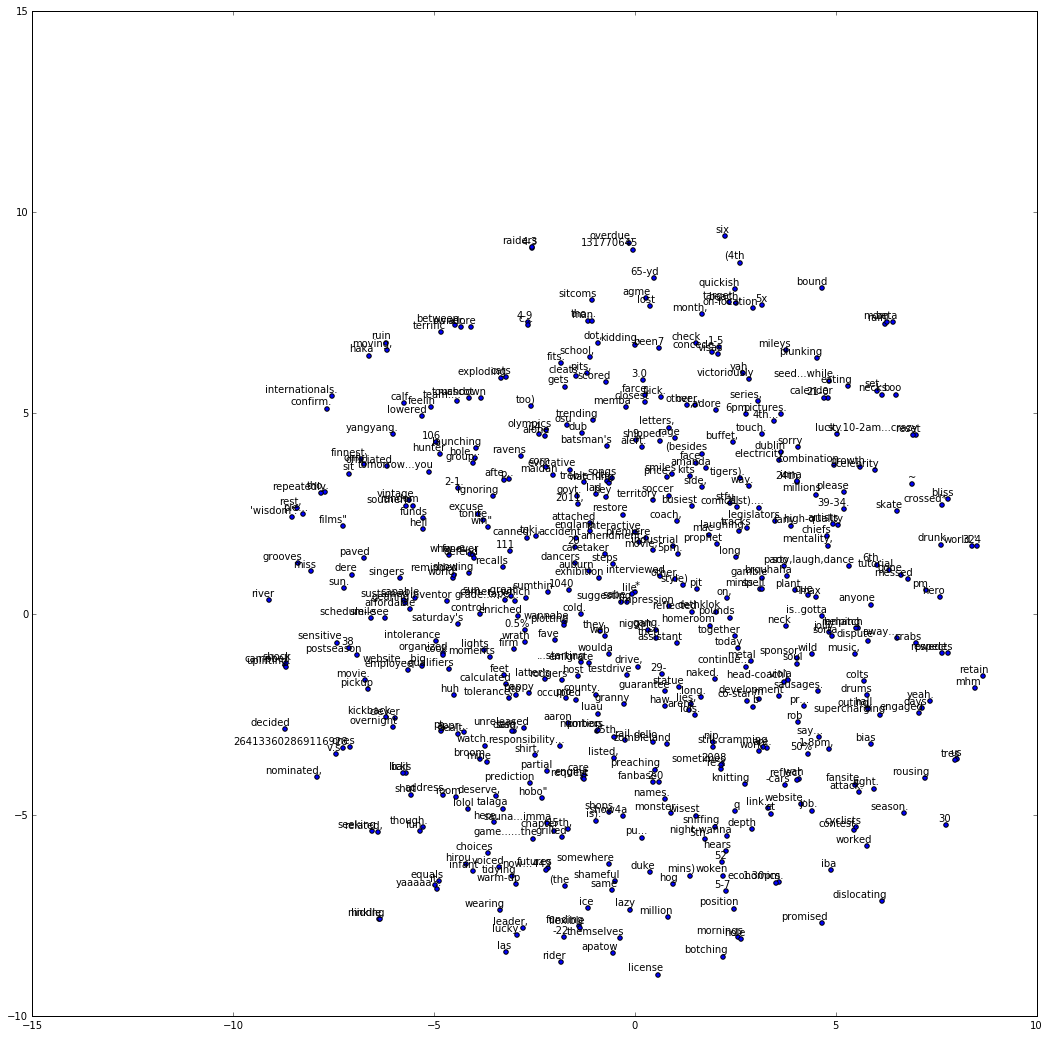

In [45]:
%matplotlib inline

def plot_with_labels(low_dim_embs, labels, filename='tsne_wiki.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(learning_rate = 300, init='pca', n_iter=5000)
    plot_only = 500
    labels = vocab[:plot_only]
    low_dim_embs = tsne.fit_transform([data_dict[label] for label in labels])
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")


## Step 2  - Get the polarity of the some words

In [46]:
import re
from nltk import word_tokenize
HL_posLoc = '/Users/gautamborgohain/PycharmProjects/DT_Labs/PLayground/Gautam_Borg/HuLiuLexicon/positive-words.txt'
HL_negLoc = '/Users/gautamborgohain/PycharmProjects/DT_Labs/PLayground/Gautam_Borg/HuLiuLexicon/negative-words.txt'

poshand = open(HL_posLoc)
neghand = open(HL_negLoc)
poslist = [re.sub(r'\n','',line) for line in poshand]
neglist = [re.sub(r'\n','',line) for line in neghand]

print(len(poslist),len(neglist))

2006 4783


## Step 3 - Match the embeddings to the polarities

In [47]:

words_in_vocab = []
polarity = []
for pos in poslist:
    if pos in vocab:
        words_in_vocab.append(pos)
        polarity.append(1)
for neg in neglist:
    if neg in vocab:
        words_in_vocab.append(neg)
        polarity.append(0)
        


In [48]:
embeddings = [data_dict[word] for word in words_in_vocab]
print(len(words_in_vocab), len(polarity), len(embeddings))

948 948 948


Allmost all the words in the lexicon are present in the vocabulary of the embeddings

In [49]:
training_df = pd.DataFrame({'Word' : words_in_vocab,'Embeddings' : embeddings, 'Polarity':polarity})
training_df.head()

,Embeddings,Polarity,Word
0,"[-0.030091, -0.023018, -0.01887, 0.035627, 0.0...",1,accomplished
1,"[0.057649, -0.07128, 0.086641, 0.019658, -0.00...",1,achievement
2,"[0.045266, 0.068517, 0.01849, 0.089882, 0.0157...",1,admire
3,"[-0.048926, -0.005944, 0.04978, 0.054353, 0.02...",1,adorable
4,"[0.042803, -0.067725, 0.061282, 0.088374, -0.0...",1,adore


In [50]:
import pickle
training_df.to_pickle('/Users/gautamborgohain/Desktop/train_tweet_DL.pck')

pickle.dump(data_dict, open("/Users/gautamborgohain/Desktop/semeval_embeds_DL.pck", "wb"))

In [18]:
import pandas as pd
training_df = pd.read_pickle('/Users/gautamborgohain/Desktop/train_tweet_DL.pck')
import pickle
model = pickle.load(open("/Users/gautamborgohain/Desktop/semeval_embeds_DL.pck",'rb'))

# Step 4  - Train a softmax classifier on this data

In [51]:
import tensorflow as tf

size = len(training_df.Embeddings[0])

sess = tf.InteractiveSession()

# Create the model
x = tf.placeholder(tf.float32, [None,size])
W = tf.Variable(tf.zeros([size, 2]))
b = tf.Variable(tf.zeros([2]))
y = tf.nn.softmax(tf.matmul(x, W) + b)

y_ = tf.placeholder(tf.float32, [None, 2])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.AdagradOptimizer(0.5).minimize(cross_entropy)

# Train
tf.initialize_all_variables().run()

In [52]:
X = [x for x in training_df.Embeddings]
Y = [[1 if y == 1 else 0,1 if y == 0 else 0] for y in training_df.Polarity]

In [53]:
epoch = 100
for ep in range(epoch):
    train_step.run({x: X, y_: Y})
    
predictions = tf.Print(y,[y])
probs = predictions.eval({x:X})

In [54]:
training_df['POS_SCORE'] = [out[0] for out in probs]
training_df['NEG_SCORE'] = [out[1] for out in probs]
training_df['LEX'] =[1 if row.POS_SCORE > row.NEG_SCORE else 0 for index, row in training_df.iterrows()]

In [56]:
training_df.LEX.value_counts()
    

0    906
1     42
Name: LEX, dtype: int64

In [57]:
training_df[0:10]

,Embeddings,Polarity,Word,POS_SCORE,NEG_SCORE,LEX
0,"[-0.030091, -0.023018, -0.01887, 0.035627, 0.0...",1,accomplished,0.426088,0.573912,0
1,"[0.057649, -0.07128, 0.086641, 0.019658, -0.00...",1,achievement,0.385293,0.614707,0
2,"[0.045266, 0.068517, 0.01849, 0.089882, 0.0157...",1,admire,0.452273,0.547727,0
3,"[-0.048926, -0.005944, 0.04978, 0.054353, 0.02...",1,adorable,0.441816,0.558184,0
4,"[0.042803, -0.067725, 0.061282, 0.088374, -0.0...",1,adore,0.431251,0.568749,0
5,"[0.005778, 0.04569, 0.058256, 0.036022, -0.087...",1,advanced,0.390152,0.609848,0
6,"[0.094524, -0.026724, 0.073506, -0.040868, 0.0...",1,advocates,0.488748,0.511252,0
7,"[-0.01367, 0.028856, -0.003339, 0.076152, 0.03...",1,affectionate,0.460360,0.539640,0
8,"[0.088238, -0.00417, 0.015918, -0.019841, 0.03...",1,afford,0.394742,0.605258,0
9,"[-0.077316, 0.05503, 0.086176, -0.01566, -0.04...",1,affordable,0.404695,0.595305,0


In [58]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(training_df.Polarity,training_df.LEX))
print(classification_report(training_df.Polarity,training_df.LEX))
print(pd.crosstab(training_df.Polarity, training_df.LEX))

0.613924050633
             precision    recall  f1-score   support

          0       0.60      0.99      0.75       554
          1       0.83      0.09      0.16       394

avg / total       0.70      0.61      0.50       948

LEX         0   1
Polarity         
0         547   7
1         359  35


*Same process with SVM - Not used*

In [59]:
from sklearn.svm import SVC

clf = SVC(kernel='linear',probability=True)
clf.fit(X,training_df.Polarity)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
clf.score(X,training_df.Polarity)

0.6371308016877637

In [61]:
preds = clf.predict_proba(X)
training_df['SVM_POS_SCORE'] = [pred[1] for pred in preds ]
training_df['SVM_NEG_SCORE'] = [pred[0] for pred in preds ]
training_df['SVM_LEX'] =[1 if row.SVM_POS_SCORE > row.SVM_NEG_SCORE else 0 for index, row in training_df.iterrows()]

# Step 5 Use the classifier to get the polarity of the rest of the words based on the embeddings

In [64]:
X = [model[word] for word in vocab]

In [65]:
predictions = tf.Print(y,[y])
probs_1 = predictions.eval({x:X})

In [66]:
probs_2 = clf.predict_proba(X)

In [67]:
probs_2[0:10]

array([[ 0.56513125,  0.43486875],
       [ 0.54706996,  0.45293004],
       [ 0.6363043 ,  0.3636957 ],
       [ 0.56928804,  0.43071196],
       [ 0.67947548,  0.32052452],
       [ 0.55793575,  0.44206425],
       [ 0.63060163,  0.36939837],
       [ 0.62346368,  0.37653632],
       [ 0.52876798,  0.47123202],
       [ 0.56745366,  0.43254634]])

# Step 6 -  Save the predictions as Lexicons

In [69]:
lex_dict = dict()
for word,index in zip(vocab,range(len(vocab))):
    lex_dict[word] = probs_1[index]
    
pos_lex = []
neg_lex = []
for key,val in lex_dict.items():
    if val[0] > val[1]:
        pos_lex.append(key)
    else:
        neg_lex.append(key)
    
pos_lex.sort()
neg_lex.sort()

In [70]:
f = open('/Users/gautamborgohain/Desktop/pos_lex_tweet_DL.txt', mode = 'w')
for word in pos_lex:
    f.writelines(str(word + '\t' + str(lex_dict[word]) + '\n'))
f.close()
f = open('/Users/gautamborgohain/Desktop/neg_lex_tweet_DL.txt', mode = 'w')
for word in neg_lex:
    f.writelines(str(word + '\t' + str(lex_dict[word]) + '\n'))
f.close()


### Lexicon Stats

In [71]:
print('POSITIVE :', len(pos_lex))
print('NEGATIVE :', len(neg_lex))

only_words_pos = [word for word in pos_lex if re.match(r'^[a-z]+$',word)]
only_words_neg = [word for word in neg_lex if re.match(r'^[a-z]+$',word)]

print('POSITVE_WORDS :', len(only_words_pos))
print('NEGATIVE_WORDS :', len(only_words_neg))

POSITIVE : 496
NEGATIVE : 14644
POSITVE_WORDS : 241
NEGATIVE_WORDS : 6963


*Read*

In [53]:
f = open('/Users/gautamborgohain/Desktop/pos_lex_tweet_DL.txt', mode = 'r')
pos_lex = [re.sub(r'\n','',word) for word in f.readlines()]
f.close()
f = open('/Users/gautamborgohain/Desktop/neg_lex_tweet_DL.txt', mode = 'r')
neg_lex = [re.sub(r'\n','',word) for word in f.readlines()]
f.close()

# Step 7 - Try out the lexicon on the test dataset

In [72]:
test = pd.read_excel('/Users/gautamborgohain/CI Submission/Data/SemEval Test.xlsx')
test = test[test.Tweet != 'Not Available']
print(len(test))
print(test.Sentiment.value_counts())
test.head()

7849
neutral     3548
positive    2970
negative    1331
Name: Sentiment, dtype: int64


,ID,USER ID,Sentiment,Tweet,Unnamed: 4
1,282031301962395008,T14111200,neutral,dec 21st 2012 will be know not as the end of t...,NaN
2,11975,SM112166,negative,Yar he quite clever but aft many guesses lor. ...,Yes.
3,136592,LJ112295,negative,Yeah we have Thin Lizzy here I HATE the inform...,Not Available
4,253421252956544992,T13114433,neutral,"MT @LccSy #Syria, Deir Ezzor: Ali Bashar al-th...",NaN
5,220880422320603008,T14114138,negative,"@MacMiller hate my life, because i can't see y...",NaN


In [73]:
sentiment_dict = {'positive':1,'negative':-1,'neutral':0}
test.replace({'Sentiment':sentiment_dict}, inplace= True)

### Unsupervised classification

- Read lexicon for each token: for word w -> [p(pos), p(neg)]
- Get the polarity if coparing the pos and the neg scores
    - if p(pos) - p(neg) > 3 ; *Positive*
    - if p(pos) - p(neg) between -3,3 ; *Neutral*
    - if p(pos) - p(neg) < -3; *Negative*

In [74]:
from nltk import word_tokenize
import numpy as np
predictions = []

for tweet in test.Tweet:
    sent_score = [0,0]
    for token in word_tokenize(tweet):
        token = token.lower()
        try:
            vals = lex_dict[token]
            sent_score = np.add(sent_score,vals)
        except Exception as e :
            vals = [0,0]#Do nothing?
    predictions.append(sent_score)


In [75]:
window = 7.0
polarity = [1 if preds[0] - preds [1] >= window else 0 if 0 <= abs(preds[0] - preds[1]) < window else -1 for preds in predictions]
test['Predictions'] = polarity

In [76]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(test.Sentiment,test.Predictions))
print(classification_report(test.Sentiment,test.Predictions))
print(pd.crosstab(test.Sentiment,test.Predictions))

0.452032106001
             precision    recall  f1-score   support

         -1       0.22      0.00      0.00      1331
          0       0.45      1.00      0.62      3548
          1       0.00      0.00      0.00      2970

avg / total       0.24      0.45      0.28      7849

Predictions  -1     0
Sentiment            
-1            2  1329
 0            2  3546
 1            5  2965


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalizing the prediction and only comparing positive and negative classes

In [77]:
def normalize(lst):
    s = sum(lst)
    return  [i/s for i in lst]

norm_preds = normalize(predictions)

polarity = [1 if preds[0] - preds [1] > 0  else -1 for preds in norm_preds]

test['Predictions'] = polarity

test_temp = test[test.Sentiment != 0]
print(accuracy_score(test_temp.Sentiment,test_temp.Predictions))
print(classification_report(test_temp.Sentiment,test_temp.Predictions))
print(pd.crosstab(test_temp.Sentiment,test_temp.Predictions))

0.647988839805
             precision    recall  f1-score   support

         -1       0.46      0.72      0.56      1331
          1       0.83      0.62      0.71      2970

avg / total       0.71      0.65      0.66      4301

Predictions    -1     1
Sentiment              
-1            952   379
 1           1135  1835


### Supervised learning - SVM

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import word_tokenize

class lexicon_feats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, frame):
        predictions = []
        for tweet in frame:
            sent_score = [0,0]
            scores = []
            max_pos_score = 0
            max_neg_score = 0
            for token in word_tokenize(tweet):
                token = token.lower()
                try:
                    vals = lex_dict[token]
                    sent_score = np.add(sent_score,vals)
                    scores.append(vals)
                    if abs(val[0]) > max_pos_score:
                        max_pos_score = val[0]
                    if abs(val[1]) > max_neg_score:
                        max_neg_score = val[1]
                except Exception as e :
                    vals = [0,0]#Do nothing- can use dict get method instead of try catch
            sent_score = np.append(sent_score , 1 if sent_score[0] - sent_score [1] >= 3.0 else 0 if 0 <= abs(sent_score[0] - sent_score[1]) < 3.0 else -1)
            #Total count of positve and negative words
            pos_count = len([1 for score in scores if score[0]>score[1]])
            neg_count = len([1 for score in scores if score[0]<score[1]])
            #Last word score
            last_word_score = scores[-1] if(len(scores)> 0) else [0,0]
            sent_score = np.append(sent_score,[pos_count,neg_count,max_pos_score,max_neg_score, last_word_score[0],last_word_score[1]])
            predictions.append(sent_score)
        return np.matrix(predictions)

In [79]:
import pandas as pd
df = pd.read_csv('/Users/gautamborgohain/CI Submission/Data/SEmEval_train.tsv', sep = '\t',header = None)

df = df[df[3] != 'Not Available']
sentiment_dict = {'positive':1,'negative':-1,'neutral':0}
df.replace({2:sentiment_dict}, inplace= True)

X = df[3]
y = [int(y) for y in df[2]]
Xt = test.Tweet
yt = test.Sentiment

baseline

In [80]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, classification_report

pipeline = Pipeline([
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True))
                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(classification_report(yt,predictions))
print(f1_score(predictions,yt,average='macro', labels = [1,-1]))

0.622372276723
             precision    recall  f1-score   support

         -1       0.54      0.34      0.41      1331
          0       0.62      0.73      0.67      3548
          1       0.65      0.62      0.63      2970

avg / total       0.62      0.62      0.61      7849

0.523011344534


With lexicon

In [81]:
pipeline = Pipeline([
    ('features', FeatureUnion([
                    ('bow', CountVectorizer(stop_words='english',lowercase=True)),
                    ('lex', lexicon_feats())
                ])
    ),
    ('svm', LinearSVC())    
    ])

pipeline.fit(X,y)
predictions  = pipeline.predict(Xt)
print(accuracy_score(predictions, yt)) 
print(classification_report(yt,predictions))
print(f1_score(predictions,yt,average='macro', labels = [1,-1]))

0.628360300675
             precision    recall  f1-score   support

         -1       0.55      0.34      0.42      1331
          0       0.62      0.74      0.68      3548
          1       0.66      0.62      0.64      2970

avg / total       0.62      0.63      0.62      7849

0.529578632126
